# Gene Expression Data (Golub 1999) - [Source link](https://www.kaggle.com/crawford/gene-expression)

Classifying two different types of leukemia based on 72 gene expression samples.

![](https://i.imgur.com/QQrxDpu.png)

(Image taken from [1])

# Data preprocessing

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from sklearn import feature_selection, feature_extraction, manifold, decomposition, cluster
from sklearn import linear_model, svm, neural_network, model_selection, preprocessing, tree, ensemble
from sklearn import gaussian_process, pipeline, metrics, dummy, ensemble, naive_bayes, neighbors

from scipy.cluster import hierarchy
from scipy.spatial import distance

import eli5
import xgboost
import skopt
import seaborn as sns

from skrebate import ReliefF
from skopt.space import Integer, Real, Categorical

from xgboost import XGBClassifier

In [3]:
train = pd.read_csv("data/data_set_ALL_AML_train.csv", delimiter=",")
test = pd.read_csv("data/data_set_ALL_AML_independent.csv", delimiter=",")
actual = pd.read_csv("data/actual.csv")

In [ ]:
# Training data preparation

As mentioned in some of the references, the split in the dataset by Golub [1] wasn't done independently. The test data comes '

In [183]:
X_train = (train.drop(["Gene Description", "Gene Accession Number"], axis=1)
                .drop([col for col in train.columns if "call" in col], axis=1)).values.T.astype(np.float32)

X_test = (test.drop(["Gene Description", "Gene Accession Number"], axis=1)
               .drop([col for col in test.columns if "call" in col], axis=1)).values.T.astype(np.float32)

X = np.vstack([X_train, X_test])
X_orig = X

labels = actual.cancer.values
y = preprocessing.LabelEncoder().fit_transform(labels)

descriptions = np.array(list(map(lambda x: x[:13], train["Gene Description"])))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, shuffle=True)

def threshold(x):
    xx = x.copy()
    c = 5
    xx[xx > c] = c
    xx[xx < -c] = -c
    
    return xx

pipe = pipeline.make_pipeline(
    preprocessing.RobustScaler(quantile_range=[1,99]),
    preprocessing.StandardScaler(),
    preprocessing.FunctionTransformer(threshold)
)

X = pipe.fit_transform(X)

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

# Value distribution after normalization

Scaling to a range represented by the 98% interval around mean, outliers are clipped after that.

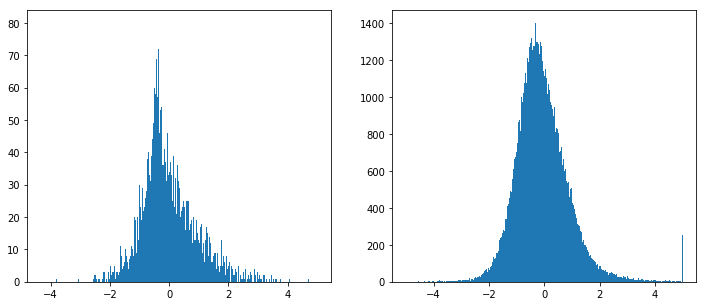

In [89]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(X_train.reshape(-1), bins=500)
plt.subplot(122)
plt.hist(X_test.reshape(-1), bins=500);

## Helper functions

In [131]:
def plot(features, labels, train=True, figure=True, xticks=False, showmask=False, use_cmap="magma"):
    if figure:
        plt.figure(figsize=(12,5))
    
    if xticks:
        plt.xticks(range(len(idx)), descriptions[idx], rotation="vertical")
        
    plt.yticks(range(len(features)), labels)
    plt.imshow(features, cmap=use_cmap)
    
# Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Feature selection using RFE

Based on \[2] and \[3] feature selection is performed using recursive feature elimination combined with a linear SVM. The algorithm iteratively trains a model and drops the least important feature (based on the lowest weight for example).

In [ ]:
rfe = feature_selection.RFE(svm.LinearSVC(), 64, step=10, verbose=1)
%time rfe.fit(X_train, y_train)

X = rfe.transform(X)
X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)

In [189]:
X.shape, X_train.shape, X_test.shape

((72, 64), (54, 64), (18, 64))

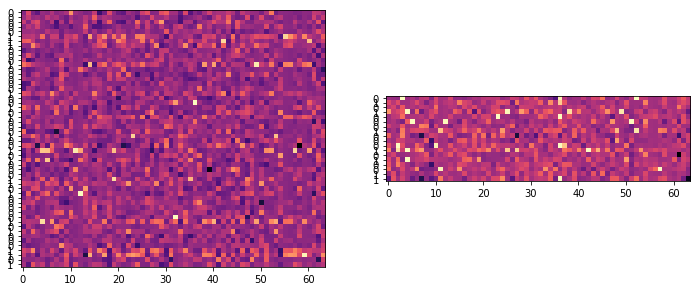

In [190]:
plt.figure(figsize=(12,6))
plt.subplot(121); plot(X_train, y_train, figure=False)
plt.subplot(122); plot(X_test, y_test, figure=False)

# PCA - the first 50 components explain all the variance

In [191]:
X_orig_train, X_orig_test, y_orig_train, y_orig_test = model_selection.train_test_split(X_orig, y, shuffle=True)

pca = decomposition.PCA(n_components=100)
X_train_embed = pca.fit_transform(X_orig_train)
X_test_embed = pca.transform(X_orig_test)

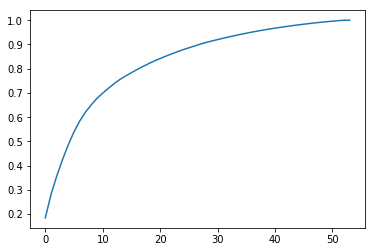

In [192]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [193]:
metrics.accuracy_score(svm.LinearSVC().fit(X_train_embed, y_orig_train).predict(X_test_embed), y_orig_test)

0.7777777777777778

Only **77% accuracy when using PCA** -> dimensionality reduction overfitting on the training set.

# Bayesian optimization

Here we just define many different models with hyperparameter ranges and search for the best combination.

In [ ]:
pipe = pipeline.Pipeline([("model", linear_model.LogisticRegression())])

search_logreg = {
    "model": [linear_model.LogisticRegression(dual=True, solver="liblinear")],
    "model__C": Real(0.1, 100, "log_uniform")
}

search_svm_rbf = {
    "model": [svm.SVC(kernel="rbf")],
    "model__C": Real(0.1, 100, "log_uniform"),
    "model__gamma": Real(0.1, 100, "log_uniform")
}

search_svm_linear = {
    "model": [svm.LinearSVC()],
    "model__C": Real(0.1, 100, "log_uniform"),    
}

search_svm_poly = {
    "model": [svm.SVC(kernel="poly")],
    "model__C": Real(0.1, 100, "log_uniform"),
    "model__degree": Integer(1, 10),
    "model__gamma": Real(1e-6, 1e3, "log_uniform")
}

search_svm_rbf = {
    "model": [svm.SVC(kernel="rbf")],
    "model__C": Real(0.1, 100, "log_uniform"),
    "model__gamma": Real(1e-6, 1e3, "log_uniform")
}

search_forest = {
    "model": [ensemble.RandomForestClassifier()],
    "model__n_estimators": Integer(5, 500),
    "model__max_depth": Integer(2, 5),
    "model__min_samples_split": Integer(2, 10),
    "model__min_samples_leaf": Integer(1, 10)
}

search_adaboost = {
    "model": [ensemble.AdaBoostClassifier()],
    "model__n_estimators": Integer(5, 500)
}

search_nb = {
    "model": [naive_bayes.BernoulliNB()],
    "model__alpha": Integer(1, 10)
}

search_knn = {
    "model": [neighbors.KNeighborsClassifier()],
    "model__n_neighbors": Integer(1, 20)
}

opt = skopt.BayesSearchCV(pipe, [
    (search_logreg, 10),
    (search_svm_linear, 10),
    (search_svm_poly, 20),
    (search_svm_rbf, 15),
    (search_forest, 20),
    (search_adaboost, 8),
    (search_nb, 8),
    (search_knn, 5)
], n_jobs=10, verbose=0)

%time opt.fit(X, y)
opt.best_score_

Naive bayes wins with **86.5% accuracy**.

In [198]:
best_estimator = naive_bayes.BernoulliNB(1.2)

In [199]:
model_selection.cross_val_score(best_estimator, X, y, cv=10).mean()

0.8654761904761905

# Best classifier results

Confusion matrix, without normalization
[[46  1]
 [ 8 17]]


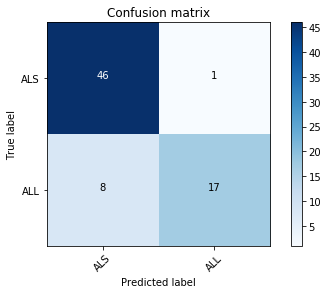

In [200]:
y_pred = model_selection.cross_val_predict(best_estimator, X, y)
cm = metrics.confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, ["ALS", "ALL"])

# Genetic Programming with TPOT

[TPOT](https://github.com/EpistasisLab/tpot) uses genetic programming to automatically create a ML pipeline.

In [23]:
import tpot

In [ ]:
pot = tpot.TPOTClassifier(generations=20, population_size=5, verbosity=2, n_jobs=10)
pot.fit(X, y)

In [32]:
pot.export("best_tpot.py")

True

In [33]:
!type "best_tpot.py"

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=42)

# Score on the training set was:0.9285714285714286
exported_pipeline = BernoulliNB(alpha=10.0, fit_prior=False)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


**Naive bayes wins evolution at 86.1% cross validation accuracy**.

In [202]:
model_selection.cross_val_score(naive_bayes.BernoulliNB(alpha=10.0, fit_prior=False), X, y, cv=10).mean()

0.8613095238095237

# Autoencoder

An alternative way to do non-linear dimensionality reduction.

In [203]:
import tensorflow as tf

C:\dev\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [205]:
z_dim = 20

input_shape = X_orig_train.shape[1]
tf.reset_default_graph()

img = tf.placeholder(tf.float32, shape=[None, input_shape], name="img")

def encoder(img):
    with tf.variable_scope("encoder"):
        hidden = tf.layers.dense(img, 500, activation=tf.nn.relu)
        hidden = tf.layers.dense(hidden, 500, activation=tf.nn.relu)
    
    return hidden

def decoder(z):
    with tf.variable_scope("decoder"):
        hidden = tf.layers.dense(z, 500, activation=tf.nn.relu)
        hidden = tf.layers.dense(hidden, 500, activation=tf.nn.relu)
        
    out = tf.layers.dense(hidden, input_shape, name="output")    
    return out

z = encoder(img)
out = decoder(z)

loss = tf.losses.mean_squared_error(img, out)

global_step = tf.train.create_global_step()
training = tf.train.AdamOptimizer().minimize(loss, global_step=global_step, name="training")

summary_writer = tf.contrib.summary.create_file_writer("logs", flush_millis=5*1000)

with summary_writer.as_default(), tf.contrib.summary.record_summaries_every_n_global_steps(100):
    summaries = [
        tf.contrib.summary.scalar("loss", loss)
    ]
    
try:
    sess.close()
except NameError:
    print("No session defined, continuing.")

sess = tf.InteractiveSession()

with summary_writer.as_default():
    tf.contrib.summary.initialize(session=sess, graph=tf.get_default_graph())

init = tf.global_variables_initializer()
sess.run(init)

Instructions for updating:
Use the retry module or similar alternatives.
No session defined, continuing.


We train the autoencoder for 1000 epochs (checked externally that this is enough).

In [206]:
for _ in range(1000):
    sess.run([training, summaries], feed_dict={img: X_orig_train})

And create embeddings of the original training set.

In [226]:
X_embed = sess.run(z, feed_dict={img: X_orig})
X_train_embed = sess.run(z, feed_dict={img: X_orig_train})
X_test_embed = sess.run(z, feed_dict={img: X_orig_test})

And score them first on the test set, which seems to give good accuracy.

In [224]:
def score_emb(clf):    
    return clf.fit(X_train_embed, y_orig_train).score(X_test_embed, y_orig_test)

Specifically, SVM with a polynomial kernel gets **94.4% accuracy**.

In [225]:
score_emb(svm.SVC(kernel="poly", degree=2))

0.9444444444444444

But this is yet again a lie, because our test set is small. Using 10-fold cross validation reveals only **65% accuracy**.

In [230]:
model_selection.cross_val_score(svm.SVC(), X_embed, y, cv=10).mean()

0.6553571428571429

# Clustering

In [266]:
pipe = pipeline.make_pipeline(
    preprocessing.RobustScaler(quantile_range=[1,99]),
    preprocessing.StandardScaler(),
    preprocessing.FunctionTransformer(threshold)
)


X_p = pipe.fit_transform(X_orig)

assignments = np.argmax(cluster.KMeans(5).fit_transform(X_p.T), axis=1)

In [267]:
X_vis = decomposition.PCA(2).fit_transform(X_p.T)

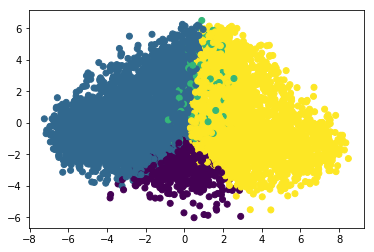

In [268]:
plt.scatter(X_vis[:,0], X_vis[:,1], c=assignments)

In [ ]:
X_vis_tsne = manifold.TSNE(verbose=3).fit_transform(X_p.T)

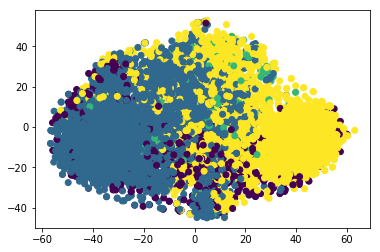

In [273]:
plt.scatter(X_vis_tsne[:,0], X_vis_tsne[:,1], c=assignments)

In [232]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# References

1. Golub, Todd R., et al. "Molecular classification of cancer: class discovery and class prediction by gene expression monitoring." science 286.5439 (1999): 531-537.
2. Duan, Kai-Bo, et al. "Multiple SVM-RFE for gene selection in cancer classification with expression data." IEEE transactions on nanobioscience 4.3 (2005): 228-234.
3. Pirooznia, Mehdi, et al. "A comparative study of different machine learning methods on microarray gene expression data." BMC genomics 9.1 (2008): S13.
4. Guyon, Isabelle, et al. "Gene selection for cancer classification using support vector machines." Machine learning 46.1-3 (2002): 389-422.